**Demo Exercise - Understanding Vector Space Models**

In this exercise, we'll experiment with how different types of queries affect the our toy semantic search Word2Vec model. In this notebook, we'll build that model again from scratch, using the top 1000 passages that we downloaded about the transatlantic slave trade.

In order to create and train our Word2Vec models, we'll have to make use of some fairly basic linear algebra. Thankfully, there's a Python library that will do much of the math for us.

Remember, when we submit our queries, we'll be checking to see which aggregate word vectors in the dataset are closest, in terms of cosine similarity, to our aggregate query vector. This is the rough example that I showed you previously:

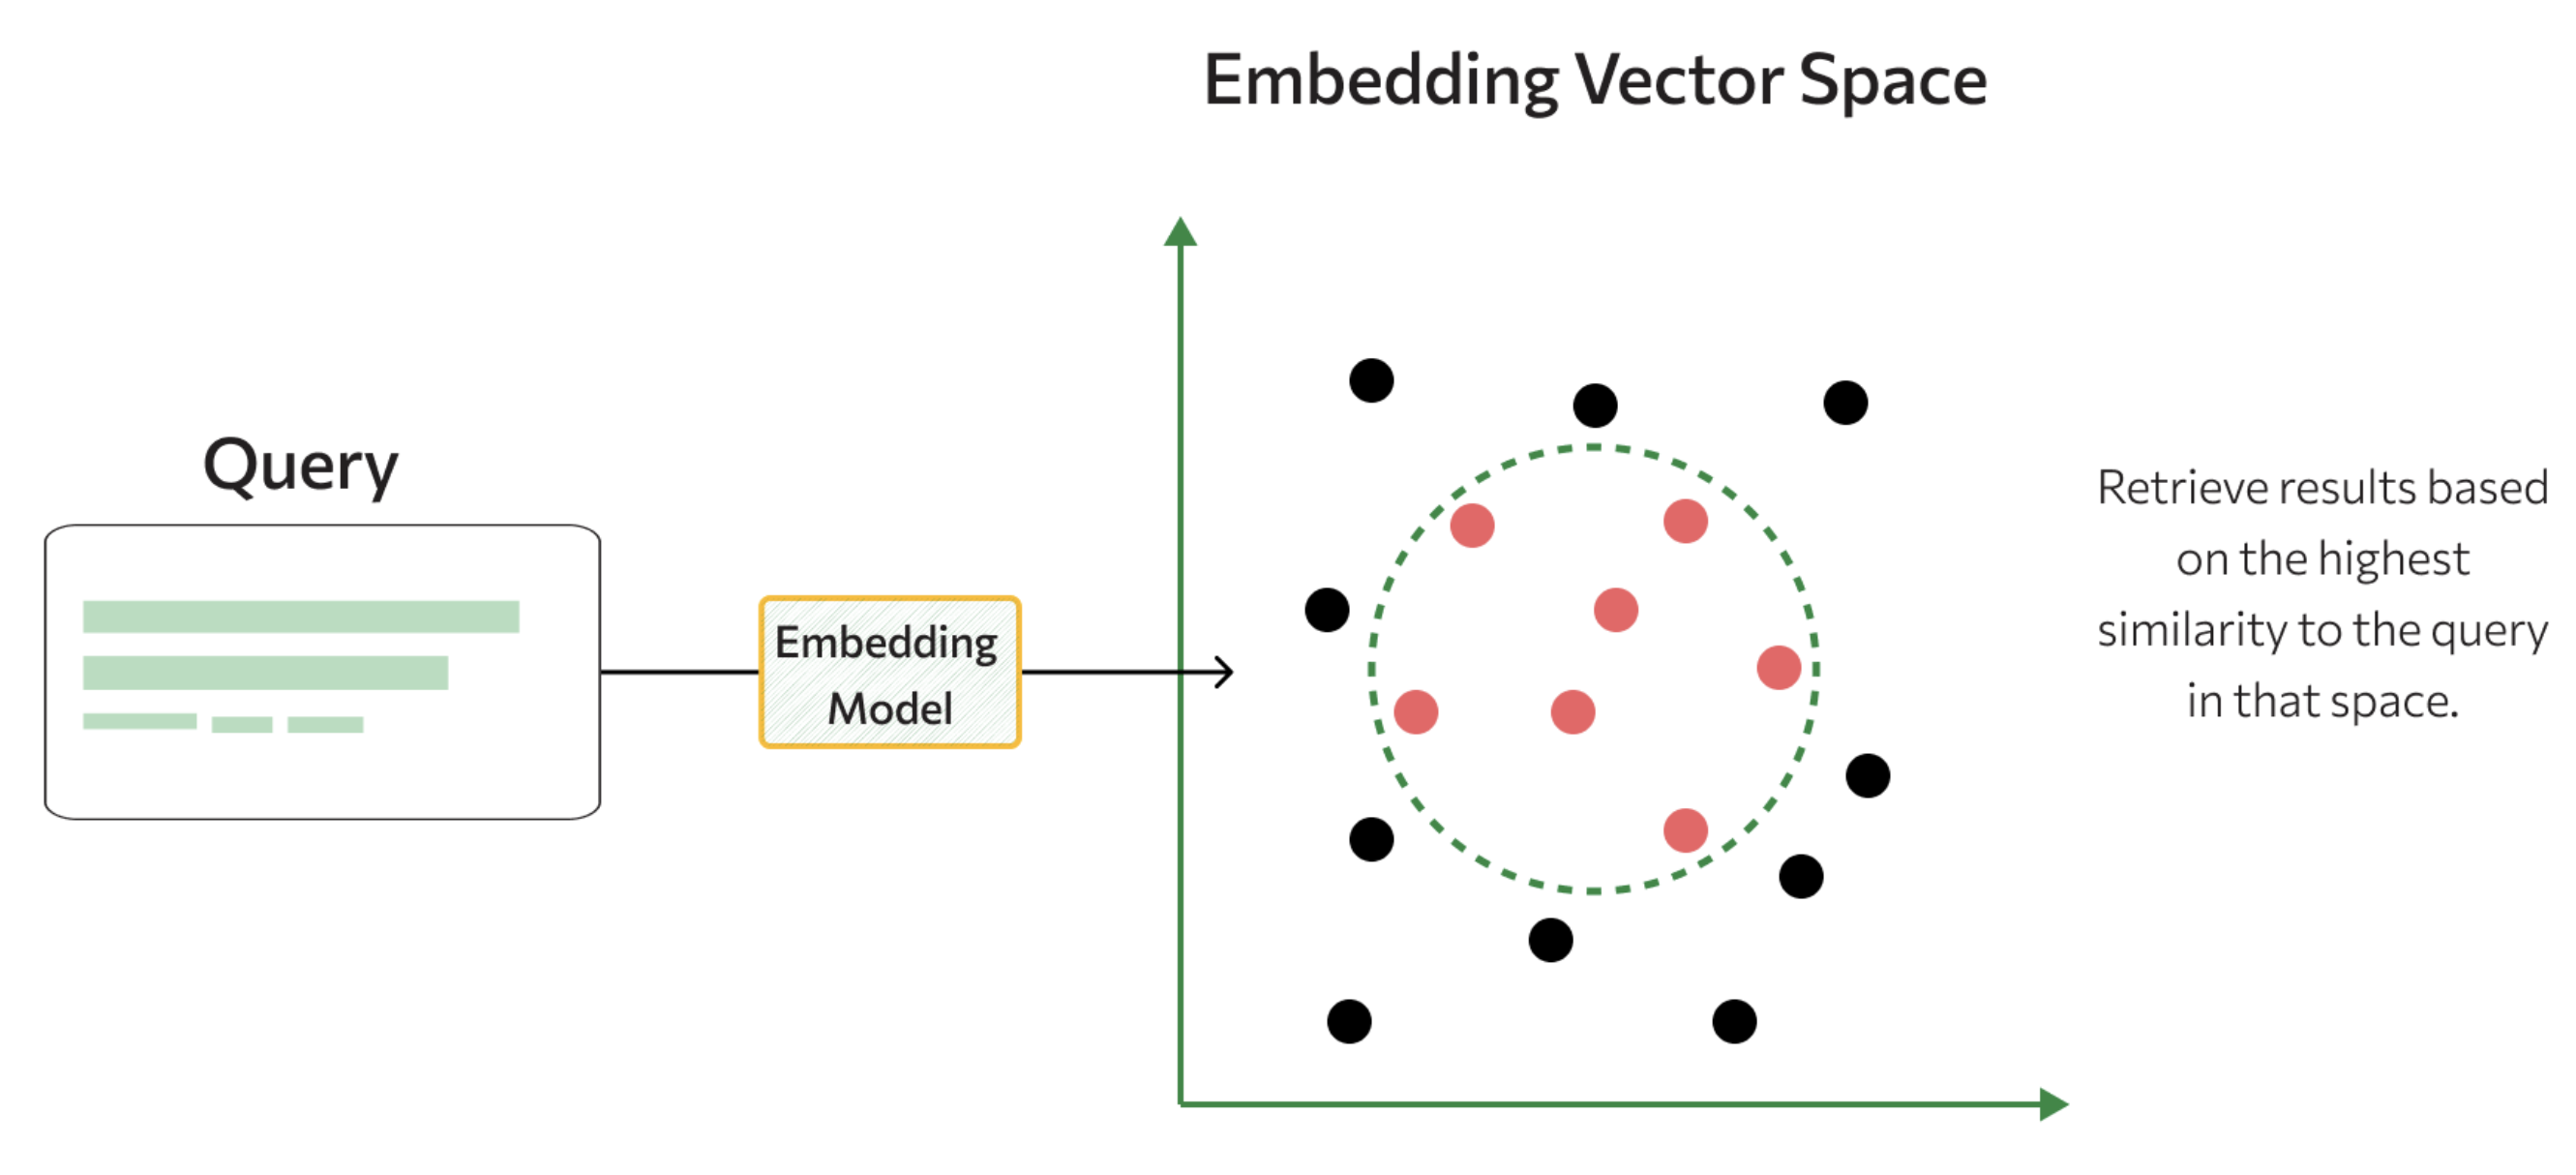



Let's get started!

**Step 1: Install gensim**

The library we will use to create and train our Word2Vec model is gensim, the same Python library we used for our lesson on topic modeling.
gensim is a Python library for topic modeling, document indexing and similarity retrieval

In [3]:
!pip install gensim

**!! - This is important**

Once you have installed gensim, you **must** make sure you restart this session. It's easy to do so, but if you skip this step, a conflict with NumPy will produce some pretty frustrating errors.

In the menu above, go to "Runtime" and click on "Restart session." Once your notebook restarts, skip Step 1 and proceed directly to Step 2.

**Step 2: Import Necessary Libraries**

As usual, we'll begin by importing the libraries that will help us streamline our code. You have used all of these in the past, except for gensim's Word2Vec and the lingalg model in NumPy.

In [2]:
import pandas as pd
import os
import numpy as np
import gensim as gensim
# Word2Vec is the model from gensim that we'll use to create word embeddings
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import re
# numpy.linalg is a module in NumPy that provides functions for linear algebra operations
from numpy.linalg import norm
from google.colab import files
print("Libraries imported.")

Libraries imported.


**Step 3: Upload the CSV File**

Now, let's get the CSV file that contains all those passages we downloaded about the slave trade. You'll have this stored on your local machine - ideally it should be in our project folder for this lesson.

In [4]:
uploaded = files.upload()
filename = next(iter(uploaded))
print(f"Successfully uploaded file: {filename}")

Saving loading_passages.csv to loading_passages.csv
Successfully uploaded file: loading_passages.csv


**Step 4: Load the CSV into a Pandas DataFrame**

This step loads your data into a dataframe, which will make it easier to access and manipulate.

In [5]:
try:
    df = pd.read_csv(filename, sep=None, encoding='utf-8', engine='python')
    print("CSV file loaded successfully!")
    print(df.head())  # Print the first few rows
    print(df.columns)  # Print column names
except FileNotFoundError:
    print(f"Error: File '{filename}' not found. Please make sure you have uploaded the file.")

CSV file loaded successfully!
         document_id                                       volume_title  \
0  0606000402_000011  The history, civil and commercial, of the Brit...   
1  0004900300_000002  The history civil and commercial, of the Briti...   
2  0151301400_000003  A short account of the African slave trade, co...   
3  0072002600_000028  A review of the principal proceedings of the P...   
4  1150400200_000029  A review of the principal proceedings of the P...   

                   volume_author  \
0       Bryan Edwards, 1743-1800   
1       Bryan Edwards, 1743-1800   
2  Norris, Robert           1791   
3                            NaN   
4                            NaN   

                                highlighted_passages  \
0  defcription of the African Coaq/. forts and Fa...   
1  CHARA.BEE ISLANDS . CHAPTER I. BARBADOS. Firt ...   
2  bloody and unrelenting Arm of Tyranny is etern...   
3  which expressly authorise and encourage the sl...   
4  islands . Is Parlia

Excellent. If that worked, you can see that our column "highlighted_passages" contains all the text we'll be using to build our vector model.


**Step 5: Specify Column with Passages and Output Directory**

We need to specify that we're particularly interested in that one column of "highlighted passages". If, for some reason, you've changed the name of that column, you should use the column that contains all your text.

In Step 6, we'll create an output directory to store all these passages as .txt files, so we may as well specify that now, while we're creating these variables.

In [6]:
passage_column = 'highlighted_passages'  # REPLACE WITH YOUR COLUMN NAME, IF DIFFERENT
output_directory = 'passages'

**Step 6: Create the Output Directory**

Here, we create that new output directory. You should be pretty used to this by now.

In [7]:
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
    print(f"Created directory: {output_directory}")
else:
    print(f"Directory already exists: {output_directory}")

Directory already exists: passages


**Step 7: Extract Passages and Save as .txt Files**
Here, we extract all the passages. If you click on the folder icon to the left, you can open the passages folder. Since our index starts at 0, our passages names will only run up to 999, but don't worry - all 1000 should be there.

In [ ]:
try:
    for index, row in df.iterrows():
        passage_text = str(row[passage_column])  # Get the passage text and convert to string
        filename = f"passage_{index}.txt"
        filepath = os.path.join(output_directory, filename)
        with open(filepath, 'w', encoding='utf-8') as f:
            f.write(passage_text)
        print(f"Created file: {filepath}")
except Exception as e:
    print(f"Error processing spreadsheet rows: {e}")
    exit()  # Stop if there's an error with row processing

In [9]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

**Step 8: Load Passages and Tokenize for Word2Vec**

Here, we'll load each of the extracted passages from the text files and tokenize them into individual "words". **You'll remember from our text processing lesson that there are lots of different ways that we can manipulate these tokens. In this case, we're just using them as-is, but that should set of warning bells! On your own, add a line of code to stem these words.**

In [10]:
corpus = []  # List to store tokenized passages
try:
    for filename in os.listdir(output_directory):
        if filename.endswith(".txt"):
            filepath = os.path.join(output_directory, filename)
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    passage_text = f.read()
                # Tokenize and lowercase the passage
                passage_words = [word.lower() for word in word_tokenize(passage_text)]
                corpus.append(passage_words)
            except Exception as e:
                print(f"Error reading or tokenizing file {filepath}: {e}")

except Exception as e:
    print(f"Error processing files in {output_directory}: {e}")

print(f"Number of tokenized passages: {len(corpus)}")

Number of tokenized passages: 1000


**Step 9: Train Word2Vec Model**

Here's where things start to get interesting! This steps trains your Word2Vec model from the tokenized passages. There are a number of different parameters to manipulate, and, as you've done in the past, you should absolutely experiment with different settings.

Read this article, if you need a refresher on how our model is built:
https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673

**vector_size**:

In this case, each word has 100 vectors. That's a pretty low level of dimensionality, but it's a start, and you can increase it if you want to attempt to encode more complex semantic relationships, but this will be more computationally burdensome. Remember that our corpus is very small, only one million words.

**window**

A window of 5 is quite specific. The model will consider that many words to the left and right to make predictions. You might want to pull up a passage and read through it: how much of a window captures related semantic context?

**min_count**

You should definitely experiment with increasing this. Remember, our goal is to eliminate as much bad OCR and meaningless function words as possible, without tossing out meaningful semantic context.

**workers**

This mainly affects training speed. If you find that your model is taking forever to load, you may want to stop the process and increase this number.

**epochs**

This is the number of passes that are made over the data, just as we saw in topic modeling. Ten is a reasonable number, and there's probably not much reason to increase this, ince we're dealing with such a small dataset. If it was larger, we could increase this to capture more specific semantic information.

In [11]:
#Parameters
vector_size = 100
window = 5
min_count = 1
workers = 4
epochs = 10

model = Word2Vec(sentences=corpus, vector_size=vector_size, window=window, min_count=min_count, workers=workers, epochs=epochs)
model.save("word2vec.model")
print("Word2Vec model trained and saved successfully!")

Word2Vec model trained and saved successfully!


**Step 10: Define Query and Parameters**

This is where you can be creative! You'll build the query vector here, either from words or passages. In the a couple of cells, you'll run this vector against your model.

This cell is built to give you options. You can build your vector either from words or passages. For this exercise, in your group, develop at least one of each of the following types:

**Query 1:** A single word.

**Query 2:** A collection of words.

**Query 3:** At least three passages of bad OCR, drawn from our top search results, which you judge to be relevant.

**Query 4:** At least three passages of clean text (you have to type it yourself, if you can't find the volume online!), drawn from our top search results, which you judge to be relevant.

**Query 5:** At least three passages of AI-generated text.

If you really want to experiment, I suggest you to try "pushing" the concept of slavery in various ways. For instance, you might try to find passages that specifically express the conditions that people endured during the middle passage. Or, you might want to try to find passages that describe people's lives before they were enslaved.


In [12]:
# CHOOSE YOUR QUERY METHOD:  Set ONE of these to True, the other to False
USE_QUERY_WORDS = True  # Set to True to use query words, False for passage(s)
USE_QUERY_PASSAGES = False  # Set to True to use full passage(s), False for words

# Load the model
model = Word2Vec.load("word2vec.model")

if USE_QUERY_WORDS:
    query_words = ["africa", "carry", "child", "coast", "colony", "condition", "country", "dutch", "foreign", "fort", "free", "french", "gold", "hand", "humanity", "indies", "island", "labour", "liberty", "manner", "nation", "native", "negro", "pain", "person", "plantation", "planter", "present", "property", "purchase", "ship", "slave", "slavery", "sold", "suffer", "sugar", "torture", "trade", "trader", "traffic", "value", "west"]
    #query_words = ["slavery"]
    # Tokenize and clean the query words - remember to stem your words, if you did so earlier!
    query_words = [word.lower() for word in query_words]
    # Create a query vector by averaging the word vectors of the query words
    query_vector = np.mean([model.wv[word] for word in query_words if word in model.wv], axis=0)
    print("Query vector created using query words.")

elif USE_QUERY_PASSAGES:
    query_passages = [
        """defcription of the African Coaq/. forts and Facories. -- Exports front Great Britain. number of Negroes tranmported annually to the briti/h Colonies . state of the Trade from 1771 to I787. numiber of Negroes at this time exported annually by the diffrent Nations of Europe, T H E progress of my work has now brought CHAP. me to the contemplation of human nature in its I. moult debased and abjet state; to the prof,, pea of 450, 000 reasonable beings (in the English Ifands only) in a state of barbarity and slavery ; of whom i will not say the major part, but great numbers assuredly, have been torn from their native country and dearest connexions, by means which no good mind can reflec upon' but with sentiments of disgust, commiseration, and sorrow! VOL. II C I am B O O I ami not unapprized of the danger I incur ac IV this juncture in treating the subjet of African ' -- Slavery , and the Slave Trade . By endeavouring to remove those wild and ill-founded notions which have been long encouraged by misinformed writers in Great Britain. to the prejudice of; ihe inhabitants of the British Sugar Islands , I am' conscious that I shall be exposed to all that " bitterness of wrath, and anger and clamour, and evil speaking and malice," with which it has long been popular to load the unfortunate slaveholder: yet nothing is more certain than that the Slave Trade may be very wicked, and the planters in general very innocent. Much the greatest part of the present inhabitants of the British West Indies came into possession of their plantations by inheritance or accident. Many persons there are, in Great Britain itself, who, amnidit the continual lu&uuation of human affairs, and the changes irr cident to property , find themselves possessed of eitates in the West Indies which they have never seen, and invested with powers over their fellow creatures there, which, however extensively odious, they have never abused : some of these gentlemen, unacquainted with local circumstances, and milled by the popular outcry, have humanely given orders to emancipate all their slaves , at whatever expense; but are convinced that their bene olent purposes cannot be carried into effect consistently even with the happiness of the Negroes thermfelves. -- The Reverend Society eftab liihed in Great Britain for propagating the Gospel in foreign parts, are themselves under this very predicament. That venerable society hold a plantation in Barbados under a devise of Co Alluding to the petitions depending in parliament; ii) for an abo!liion of the sae Tiade. lonel lonel Codrington; and they have found them. chap. selves not only under the disagreeable necessity of II supporting the system of slavery which was be' ' to them with the land; but are induced alob, from the purest and belt motives, to purchase occasionally a certain number of Negroes , in order to divide the work, and keep up the flock. They well know that moderate labour , unaccompanied with that wretched anxiety to which the poor of England are subject, in making provision for the day that is parsing over them, is a itate of comparative felicity : and they know also, that men in savage life have no incentive to emulation: persuasion is lost on such men, and compulsion, to a certain degree, is humanity and charity. The question then, and the only question wherein the character of the planters is concern. ed, is this: lmaking due allowance for human frailty under the influence of a degree of power ever dangerous to virtue, is their general con dut towards their slaves such only as necessarily results from their situation? If to this inquiry, an affirmative be returned, surely Christian charity, though it may lament and condemn the first establishment of a system of slavery among them, and the means by which it is still kept up and supported, will not hastily arraign those who neither introduced, nor, as I shall hereafter show, have been wanting in their best endeavours to corre: and remedy many of the evils of it. Having premised thus much, I shall now proceed to lay before my readers some account of the origin and present state of the Slave Trade , between the nations of Africa and such of the States of Europe as are concerned in it: this will constitute what remains of the present chap C 2 ter. B 0 0 K ter. In the next, I shall offer soil thoughts of IV the Negro character and disposition: after which '-^ -- - I shall treat, first, of the means by which slaves are procured in Africa ; secondly, of the mode of conveying them to the West Indies ; and thirdly, of their general treatment and situation when sold to the planters there: an arrangement which will afford opportunities of illustrating the foregoing observations, by enabling me to intersperse such reflections as occur to my mind on the several petitions now depending in parliament for a total abolition of the Slave Trade , all or the greatest part of which are grounded on abuses charged to exist under those several heads. In the year 1442, while the Portuguese, under the encouragement of their celebrated Prince Henry, were exploring the coast of Africa , Anthony Gonfalez, who two years before had seized fotne Moors near Cape Bojadar, was by that prince ordered to carry his prisoners back to Africa : he landed them at Rio del oro, and received from the Moors in exchange, ten Blacks, and a quantity of gold dust, with which he returned to Lisbon. The success of Gonfalez, not only awakened the admiration, but Stimulated the avarice of his countrymen; who, in the course of a few succeeding years, fitted out no less than thirty feven Ships in pursuit of the same gainful traffic . In 148, theportuguefebuilt afort on the Gold Coast ; .another, some time afterwards, on the Island of Arguin; and a third at Loango Saint Paul's, on the coast of Angola; and the king""",
        """trade of this island , it is proper to begin with the Negroe trade , which is the groundwork of all. The Negroe flves are purchased in Africa , by thebritifh merchants, with a great variety of woolle goods; a cheap, sort of firearms from Birmingham, Sheffield, and other places; powder, bullets, iron bars, copper bars, brass pans, malt spirits, tallow, tobacco pipes, Manchester goods, glass beads; some parti: ular kind of linens, ironmongery and cutlery ware; certain toys, some East-india goods; but, in the main, with very little that is not of British growth, or manufacture. Besides there slaves (which make tip the greatest part of their cargo), our African traders also purchase gold dust, elephants teeth, and dying woods, with some valuable drugs; and in the West Indies also, when they have any surplus of laves, they dispose of them at a good price to foreign nations . All the incidental profits, exclusive of what is produced by the sale of slaves , whether obtained by the purchase of other articles upon the African coasts , or from the sale of their commodities to foreigners in the West Indies , find their way into Great Britain; on the winding up of the account therefore, as the sale of the Negroes centres in the West Indies , so the profit arising upon them, and every other acceffio of gain, from whatever article of our African commerce it is produced, centres ultimately with, and becomes the property of, the inhabitants of Britain. When these Negroes are sold to the British planters , they cannot be employed in, or furnilied with, infiruments proper for their daily labour , but with fresh advantage to the Britith nation . For, in his field work, the planter must supply his Negroes with bills, hoes, and axes; his Negroc tradesmen require infiruments and tools of various sorts, which, in consequence of their being used continually, mnakes it necessary to have yearly supplies, for the making good wear and tear, which, in so moist and warm a climate, must rise to a very considerable R rr 2 alllamo t. 49t amount. To this we may add, that these people, selling no mall part of the provisions they raise, lay out the produc which thus arises from their private industry, chiefly for Birmingham, Sheffield, and Manchester wares; so that all this, which, their numbers considered, amounts to no despicable sum, is likewise returned to Great Britain d]. But the field expenses are trifling, in comparison of the utensils necessary in figar works; such as coppers, fills, mill cafes, and other mill work of iron; ladles, kimmers, lamps, and almost innumerable other articles; to which may be added riails, locks, staples, hinges, bolts, bars; and lead, employed by the planter .in his other buildings, and the numberless kinds of ironwork that .are used in wagons, carts, and other things, not only exceedingly' expensive at the filft setting out, but which, from their being in constant use, require frequent supplies. All these (at whatsoever price) must be. had.from Britain.. Even the value of [a] State of the African Trade , u latdy giverr to the'publick, for'the year 771. * Senegambia,. -..- - 43 Ships . Gold Coast , - -29 Windward Coast - - 5 Bite, - - 63 Angola, -. _-. Total 195 of.thefe 95 hiips, 107 went from Liverpool, for 29, 250 58 went from London, for * 8, i36 25 went from Brillol, for 8, 810 t egroe 5 went. from Lancaster, for. 950 47, 146 ' Befdce these (hipi there go annually, from North America and the West Indies , at least 60 or 70. and they are yearly icreafing; therefore the whole number of hips and vdefels employed in thi.; trade are about 260, and the number of Negroes they carry ; about s7, ooo, The gold imported from the Gold Coall has been in fume years 1 Soooo oa. And from Senegambia generally about 400 tonnes of gum. By a calculatimi of the trade , it appears, that at leafi one million and a half of money is annually remitted to Great Britain for Negroes and that the value of other articles imported, besides what are befere mentioned, vil. wax, ivory, malaguetta, pepper, rice, ebony, redwood, and other dying woods, amounts at leaf to half a million more; so that two millions ol money are brought home by this trade in its present late; and. it is fiuppofied, that it might be increased much more, by proper regulations. It now employs above 50, 000 tonnes of hipping, and is carried on chiefly by our own.mlnuftluires, and furnishes the colonies with 40, 000 1; - bourers yearly. The advantage to the revenue is equal to that of the merchants; and vhatltievcr is the annual value of the labour o our plantation Negroes , so in proportion is the benecit rising to government from the duties levied on the 'commodities produced by the labour ., Treatise tpon the 'rade fr m Great Britain to Aliica, 1772. the thl lumber, provisions, and other commodities, which are imported from the Northern colonies , and paid for by the sugar planters , goes in discharge of the balances refpeetively due from those colonies to the mother country ; or, at least, a very great part of them are this way discharged. - To this catalogue we mufi add many of the materials necessary for building their houses; by far the greatest part of their furniture: and it is not only by their indufiry, and the success attending. it, that'great Britain is enriched, but also by their luxuries, whenever they are in a condition to have more than the convenien cies of life, such as chaises, coaches, chariots, and the like, together with all sorts of wearing apparel, but chiefly of the finest and cost liest fabrics; no finall prt likewise of their provisions, such as cheese, hams, bacon, tongues, salmon, onions, refined sugars , con fetionary, and grocery wares, spices, pickles, beer, porter, ale, and cyder, in vast quantities; and flour, and biscuit, when they are cheap. Their Negroes aifo are""",
        """bloody and unrelenting Arm of Tyranny is eternally held up, ready to cut it down. THE Credibility of there extraordinary faas does not depend upon mere hearsay: Dahomy is a maritime Kingdom, in which the British, French , and Portuguese have been permitted to eret Sorts for the Proteaion of their Trade ; and the Veracity of ( 9) of what is here related, is authenticated by the indubitable Testimony or many who have resided there. THE Afticans have been in the practice, from Time immemorial, of selling their Countrymen, and never entertained any more Doubt of their Right to do so, than we do of sending Delinquents to Botany Bay, or to Tyburn; deeming it fair and just to difpofe of their Slaves , Prisoners of War, and Felons, according to their own established Laws and Cuoomns. Great Enormities, they punish with Death; but, unless it be in such despotic Governments as Dahomy, few but Criminals are sold to the Whites, except Prisoners taken in War; who would inevitably be put to Death, did not a more profitable Mode offer of disposing of them: and hence it is, that Persons of some Rank in their own Country , some times become Slaves in the West Indies and American Colonies ; but the House of Bondage, flttily fpeakinig, maybe called a land..ofl_.ieedom to them: where, notwithitanding they do not enjoy preeminence, they may be comfortable; and where, although prevented from exercising Cruelty on others, they are always protected themselves. Those who are guilty of Theft, Adultery, or the imputed Crime of Witchcraft, if they escape Death, are sold for Slaves . To deter them from the Commifiion of these Crimes, their Situation in foreign Slavery , is represented to be attended with the severest Tortures ; which, fortunately for them however, are not realised: as will appear hereafter. Nor is it to be wondered at, in a Country of so great Extent, and so little Civilization, that the greatest Part of the Africans, brought to the European Colonies , are condemned to Slavery , for Ads of Delinquency; since Great Britain alone, under the superior Advantages of its Religion, Laws, and Manners , produces annually above 2000 Conviais. SINCE the Labour of African Slaves has been found indif peilfibly necessary for the Cultivation of the Welt Indian Islands , B and id ation, han Plantations , from the utter iolicitous to acquire People being able to undergo that Fatigue, every European 4c, / Nation , having Colonies there, h been solicitous to acquire a hare in this Traffic ; nor has the most scrupulous of them entertained a Doubt of their Right to purchase , what the Africans bad a right to dispose of. A MONG the Adventurers in this Trade , the British possess at fre!fnt the greatef Share of it. It was during the Government of the Conmmnwvealth, that Negroes were carried , in any Numbers, m. the West Indies , and then, chiefly to Barbados: asew Negroes were taken to Virginia, by a Dutch Ship , so early as 160o; but it mwas the Royal African Company, eihablifhed in 1672, that first carried on, from hence, a vigorous Commerce to Africa . We may form an Opinion of the Magnitude of it, in its most flourish ine State, prior to the Revolution in 1688, by considering that the Company employed thirty Ships annually, which delivered about o00o Negroes in the West Indies The Increase of it to its present State, may be attributed to the enterprzing Spirit of the Merchants; to the superior Address of those employed in the executive Part of it;. to the Opulence of the Manufaturers, : which enables them to extend a Credit to the former, beyond. what can be had in any other Country ; and to the liberal Supply allowed by Government annually, for the maintenance of several' Sorts, and factories in Africa . From these concurring Circumstances, the Britilh Planters are supplied with Negroes , on more *eafonable Terms than their Neighbours; and a large Surplus left, which are disposed of to.the French and Spaniards for Specie, and. other valuable Commodities. THE Importance of this Trade to Great Britain, almodt ex ceeecalculation. It immediately employs about zo Ships , which sail annually for Africa , whose Cargoes exceed a Millon Sterling; fomse of which are the produaions of the Britifl Setolements in theeaft and Wft'r Indies ; but above 7oo00oool. is tit.) is.invelted in British Manufatlures. only. The Returns ofethde Ciargoes are conpted at a Million and an half. The Artificets and Mechanics empaloyed at Liverpool algne, receive ioo, oool. annually for Labour and Materials employed in equipping the Ships engaged in it; and exclusive of the large Sums paid for Sea. mens Wages, the Captains and Officers Commissions and Privi -- lege amount, at least, to 50, 000ooo. annually; which is generally realised there, and has contributed greatly to the rapid Increase of that flourishing Town. THE African Trade , conneted as itis with the West Indiaa Commerce, and that to the remaining continental C'ionies, and Newfoundland Fishery, is of the utmost Consequence totbe employment of many thousands of our fellow fubjeas, i the Naval Power of Britain, and to the Royal Revenues; all which are, conjoined by sympathetic Ties. The Value of three Millions, at least, of domestic Manufacures, exclusive of other Merchandise, annually find a profitable Vent by means of the African and wvet Indian Trades ; and above five Millions of Property , afifing. from the Labour of Negro Slaves , employed in the West Indian. Islands , is yearly imported from thence; which contributes not lets than a Million and an half annually to the .Revenue: of this Kingdom. To carry on this immense Traffic , and. to supply there Islands with Lumber and Provisions, from the continental Colonies , and Newfoundland Fiihery, gives constant Employment to, at least, a thousand Ships , and to above 500ooo Mariners. To enumerate the fatal Consequences that would inevitably ensue from a Check given to this extenfivecom merce, exceeds the.prefcribed Limits ofthis short Sketch, butth~e shall be hinted at in the Sequel. THE Adventurers in this Trade , who have seen for near a""" #Added another passage
    ]  # Replace with your query passages, and add more as needed.

    all_passage_words = []
    for passage in query_passages:
        # Clean the passage: lowercase, remove punctuation, etc. (adjust regex as needed). Again, remember to stem if you did so when you prepared the vector model!
        cleaned_passage = re.sub(r'[^\w\s]', '', passage.lower())
        passage_words = cleaned_passage.split()
        all_passage_words.extend(passage_words)  # Accumulate words from all passages
    query_vector = np.mean([model.wv[word] for word in all_passage_words if word in model.wv], axis=0)
    print("Query vector created using passages.")

Query vector created using query words.


**Step 11: Function to Calculate Cosine Similarity**

Here, we'll define a function to assess cosine similarity, the aggregate difference between vectors. This is what you're using to match your queries to documents.

For this function, `v1` is the first vector and `v2` is the second vector.

In [13]:
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (norm(v1) * norm(v2))

**Step 12: Calculate and Rank Passages by Similarity, storing the passage number**

In [14]:
passage_similarities = []
all_similarity_values = []
for filename in os.listdir(output_directory):
    if filename.endswith(".txt"):
        filepath = os.path.join(output_directory, filename)
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                passage_text = f.read()
            # Tokenize and lowercase the passage
            passage_words = [word.lower() for word in word_tokenize(passage_text)]
            # Get the passage vector
            passage_vector = np.mean([model.wv[word] for word in passage_words if word in model.wv], axis=0)

            if passage_vector is not None:  # Ensure passage_vector is not None
                # Calculate Cosine Similarity
                similarity = cosine_similarity(query_vector, passage_vector)
                # Extract Passage Number
                passage_number = int(filename.replace("passage_", "").replace(".txt", ""))  # Assumes that the files were created using the previous step
                passage_similarities.append((passage_number, similarity))  # Store passage # and the passage text
                all_similarity_values.append(similarity)  # NEW: collect similarity
            else:
                print(f"No words from passage {filename} were found in the Word2Vec model.")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

# Sort Results, Extract Passage Numbers Starting from 1
passage_similarities.sort(key=lambda x: x[1], reverse=True)
ranked_passage_numbers = [passage_number + 1 for passage_number, similarity in passage_similarities]
print("Ranked Passage Numbers (Starting from 1):")

average_similarity = sum(all_similarity_values) / len(all_similarity_values)
print(f"\nAverage Cosine Similarity across all passages: {average_similarity:.4f}")

Ranked Passage Numbers (Starting from 1):

Average Cosine Similarity across all passages: 0.7708


**Step 13: Create a Pandas Dataframe of New Passage Ranks from Word2Vec, Save and Download as CSV**

In [15]:
# --- Step 13: Create a Pandas Dataframe, Save and Download as CSV ---
rankings_df = pd.DataFrame({'rankings': ranked_passage_numbers})
csv_filename = "passage_rankings.csv"
rankings_df.to_csv(csv_filename, index=False)  # index=False prevents writing the index to the CSV
files.download(csv_filename)
print(f"Downloaded CSV file: {csv_filename}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded CSV file: passage_rankings.csv
